# Convolutional Neural Network

## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
import struct
from array import array
import random
from copy import deepcopy
import time

## Defining the Convolutional layer

### Parameters

$$\large n_i \rightarrow \text{Input size}$$

$$\large n_o \rightarrow \text{Output size}$$

$$\large W_{n_o \times n_i}\rightarrow \text{Weight matrix}$$

$$\large b_{n_o \times 1} \rightarrow \text{Bias vector}$$

$$\large \sigma \rightarrow \text{Activation function}$$

$$\large E \rightarrow \text{Error function}$$

### Forward Pass

$$\large z^l = W^l \cdot a^{l-1} + b^l$$

$$\large a^l = \sigma(z^l)$$ 

$$\large\text{Final output of the network, }\hat y = a^L$$


### Backward Pass

$$\large
\text{Let }\delta^l = \frac{\partial E}{\partial z^l}
$$

$$\large
\text{Then, }\delta^L = \frac{\partial E}{\partial z^L} = \frac{\partial E}{\partial \hat y} \cdot \frac{\partial \hat y}{\partial z^L}
$$

$$\large
\text{Assuming }E = -\displaystyle\sum_j y_j log(\hat y_j)
$$

$$\large \frac{\partial E}{\partial z_i^L} = -\frac{\partial}{\partial z_i^L} \sum_j y_j \cdot \ln\hat{y}_j$$

$$\large \frac{\partial E}{\partial z_i^L} = -\sum_j y_j \cdot \frac{1}{\hat{y}_j}\frac{\partial \hat{y}_j}{\partial z_i^L}$$

Let's calculate $\LARGE \frac{\partial \hat{y}_j}{\partial z_i^L}$.

For $i = j$:

$$\large
\frac{\partial \hat{y}_i}{\partial z_i^L} = \frac{\partial}{\partial z_i^L} \frac{e^{z_i^L}}{\sum_j e^{z_i^L}}
$$

$$\large
\frac{\partial \hat{y}_i}{\partial z_i^L} = \frac{ \sum_j e^{z_i^L} \times e^{z_i^L} - e^{z_i^L} \times e^{z_i^L}}{\left(\sum_j e^{z_i^L}\right)^2} = \frac{e^{z_i^L}}{ \sum_j e^{z_i^L}} \times \frac{\sum_j e^{z_i^L} - e^{z_i^L}}{\sum_j e^{z_i^L}}
$$

<div style="text-align: center;">
  <div style="border: 2px dashed white; padding: 5px; display: inline-block;">
    \( \LARGE \frac{\partial \hat{y}_i}{\partial z_i^L} = \hat{y}_i (1 - \hat{y}_i) \)
  </div>
</div>


For $i \neq j$:

$$\large
\frac{\partial \hat{y}_j}{\partial z_i^L} = \frac{\partial}{\partial z_i^L} \frac{e^{z_j^L}}{\sum_k e^{z_k^L}}
$$

$$\large
\frac{\partial \hat{y}_j}{\partial z_i^L} = -\frac{e^{z_j^L} \times e^{z^L_i}}{\left(\sum_k e^{z_k^L}\right)^2}
$$

<div style="text-align: center;">
  <div style="border: 2px dashed white; padding: 5px; display: inline-block;">
    \( \LARGE \frac{\partial \hat{y}_j}{\partial z_i^L} = -\hat{y}_j\hat{y}_i \)
  </div>
</div>


Substituting the result, we get

$$\large
\frac{\partial E}{\partial z^L_i} =  \hat{y}_i{\displaystyle \sum_{i \neq j} y_j} - y_i (1-\hat{y}_i)
$$

Which simplifies to

$$\large
\frac{\partial E}{\partial z^L_i} = - y_i +  \hat{y}_i {\displaystyle \sum_j y_j} 
$$

For one-hot encoded labels, $$\large {\displaystyle \sum_j y_j} = 1$$

Which gives
$$\large \frac{\partial E}{\partial z^L_i} =\hat{y}_i - y_i$$

$$\large \therefore \boxed{ \delta ^L = {\frac{\partial E}{\partial z^L} = \hat{y} - y}}$$


Now, for hidden layers, let's calculate $\large \delta^l$

$$\large
\delta^l = \frac{\partial E}{\partial z^l} = \frac{\partial E}{\partial a^l} \cdot \frac{\partial a^l}{\partial z^l}
$$

$$\large
\implies \delta^l = \frac{\partial E}{\partial a^l} \odot \sigma^\prime(z^l)
$$

Let's calculate $\LARGE \frac{\partial E}{\partial a^l}$


$$\large
\frac{\partial E}{\partial a^l} = \frac{\partial z^{l+1}}{\partial a^l} \cdot \frac{\partial E}{\partial z^{l+1}}
$$

$$\large
\text{Now, }z^{l+1} = W^{l+1}a^l + b^{l+1}
$$

$$\large
\implies \frac{\partial E}{\partial a^l} = (W^{l+1})^T \cdot \delta^{l+1}
$$

Thus, $\large \delta^l$ becomes

$$\large
\boxed{\delta^l = \left((W^{l+1})^T \cdot \delta^{l+1}\right) \odot \sigma^\prime(z^l)}
$$

$\underline{
\text{Gradient of Weights and Biases}}
$

$$\large
\frac{\partial E}{\partial W^l} =  \frac{\partial z^l}{\partial W^l} \cdot \frac{\partial E}{\partial z^l}
$$

$$\large
\text{Now, }z^l = W^l a^{l-1} + b^l
$$

$$\large
\implies \boxed{\frac{\partial E}{\partial W^l} =  \delta^l \cdot (a^{l-1})^T}
$$

$$\large
\text{Similarly for }b^l\text{, }
$$

$$\large
\boxed{\frac{\partial E}{\partial b^l} =  \delta^l}
$$

In [216]:
class Convolutional:
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_depth = input_depth
        self.input_shape = input_shape
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.random(self.kernels_shape)
        self.biases = np.random.random(self.output_shape)

    def forward(self, input):
        self.input = input
        batch_mode = (input.ndim == 4)
        if not batch_mode:
            input = input[np.newaxis]
    
        batch_size, _, H, W = input.shape
    
        output = cross_correlate(input, self.kernels)
        output += self.biases if batch_mode else self.biases[np.newaxis]
    
        return output if batch_mode else output[0]

        
    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        inputs_gradient = np.zeros_like(self.input)
        
        # Determine if we have batched input.
        batched = (self.input.ndim == 4)
        
        if batched:
            batch_size = output_gradient.shape[0]
            # Loop over each item in the batch.
            for k in range(batch_size):
                for i in range(self.depth):
                    for j in range(self.input_depth):
                        # --- Compute kernel gradient ---
                        # self.input[k, j] has shape (H, W). Promote to (1, 1, H, W)
                        x_patch = self.input[k, j][np.newaxis, np.newaxis, ...]
                        # Similarly, output_gradient[k, i] (shape: (out_H, out_W)) is promoted to (1, 1, out_H, out_W)
                        og = output_gradient[k, i][np.newaxis, np.newaxis, ...]
                        # Compute cross-correlation between input patch and output gradient.
                        # The call expects: input: (batch, channels, H, W) and kernel: (depth, channels, kH, kW)
                        # Here, og is treated as the “kernel” with shape (1,1,out_H, out_W). With 'valid' mode the result will be of shape
                        # (1,1, kernel_height, kernel_width), which should match self.kernels[i,j].shape.
                        k_grad = cross_correlate(x_patch, og)
                        # k_grad has shape (1, 1, kernel_height, kernel_width); extract the [0,0] slice.
                        kernels_gradient[i, j] += k_grad[0, 0]
                        
                        # --- Compute input gradient ---
                        # For input gradient, convolve the output gradient with the kernel.
                        # Promote output_gradient[k, i] to shape (1,1,out_H, out_W)
                        og2 = output_gradient[k, i][np.newaxis, np.newaxis, ...]
                        # For our kernel, self.kernels[i, j] is 2D. Promote to (1,1,kH,kW)
                        ker = self.kernels[i, j][np.newaxis, np.newaxis, ...]
                        in_grad = convolve(og2, ker, type='full')
                        # in_grad has shape (1,1,H, W); extract [0,0] and accumulate.
                        inputs_gradient[k, j] += in_grad[0, 0]
                        
            # Update parameters
            self.kernels -= learning_rate * kernels_gradient / batch_size
            self.biases  -= learning_rate * np.mean(output_gradient, axis=0)
        else:
            # Non-batched (single sample) case.
            for i in range(self.depth):
                for j in range(self.input_depth):
                    x_patch = self.input[j][np.newaxis, np.newaxis, ...]
                    og = output_gradient[i][np.newaxis, np.newaxis, ...]
                    k_grad = cross_correlate(x_patch, og)
                    kernels_gradient[i, j] += k_grad[0, 0]
                    
                    og2 = output_gradient[i][np.newaxis, np.newaxis, ...]
                    ker = self.kernels[i, j][np.newaxis, np.newaxis, ...]
                    in_grad = convolve(og2, ker, type='full')
                    inputs_gradient[j] += in_grad[0, 0]
                    
            self.kernels -= learning_rate * kernels_gradient
            self.biases  -= learning_rate * output_gradient
    
        return inputs_gradient

    
class Dense:
    def __init__(self, input_size, output_size, sigma = lambda x : x, sprime = lambda x : 1, initialization = 'He'):
        self.sigma = sigma
        self.sprime = sprime

        limit_He = np.sqrt(2 / input_size)
        limit_Xavier = np.sqrt(6/(input_size+output_size))

        if initialization == 'He':
            limit = limit_He
        else:
            limit = limit_Xavier
        
        self.W = np.random.uniform(-limit, limit, (output_size, input_size))
        self.b = np.random.uniform(-limit, limit, (output_size, 1))

    def forward(self, X):
        self.prev_a = X
        self.z = np.dot(X,self.W.T) + self.b.T
        return self.sigma(self.z)

    def backward(self, delta, learning_rate = 0.001):
        delta = np.multiply(delta, self.sprime(self.z))
        self.W -= learning_rate*np.dot(delta.T,self.prev_a)
        self.b -= learning_rate * np.sum(delta, axis=0, keepdims=True).T
        return np.dot(delta, self.W)

class ReLU:
    def __init__(self):
        self.func = self.relu
        self.prime = self.relu_prime

    def relu(self,x):
        return np.maximum(0, x)

    def relu_prime(self,x):
        return (x > 0).astype(float)

class Softmax:
    def __init__(self):
        self.func = self.softmax
        self.prime = self.softmax_prime

    def softmax(self, x):
        x = np.clip(-50,50,x)
        p = np.exp(x - np.max(x, axis=0, keepdims=True)) # Stability trick
        return p / np.sum(p, axis=0, keepdims=True)

    def softmax_prime(self, x):
        s = self.softmax(x)
        return s*(1-s)



class MaxPooling():
    def __init__(self, filter_size):
        self.filter_size = filter_size
        self.stride = filter_size

    def forward(self, input):
        self.input = np.asarray(input)
        if self.input.ndim == 3:
            self.input = self.input[np.newaxis, ...]  # Add batch dim

        N, C, H, W = self.input.shape
        out_H = -(-H // self.filter_size)
        out_W = -(-W // self.filter_size)

        self.output = np.zeros((N, C, out_H, out_W))
        self.max_mask = np.zeros_like(self.input)

        for n in range(N):
            for c in range(C):
                for i in range(out_H):
                    for j in range(out_W):
                        r_start = i * self.stride
                        r_end = min(r_start + self.filter_size, H)
                        c_start = j * self.stride
                        c_end = min(c_start + self.filter_size, W)

                        window = self.input[n, c, r_start:r_end, c_start:c_end]
                        max_val = np.max(window)
                        self.output[n, c, i, j] = max_val
                        max_idx = np.unravel_index(np.argmax(window), window.shape)
                        self.max_mask[n, c, r_start + max_idx[0], c_start + max_idx[1]] = 1

        if input.ndim == 3:
            return self.output[0]  # remove batch dim if input didn't have it
        return self.output

    def backward(self, output_gradient, dummy_parameter):
        if output_gradient.ndim == 3:
            output_gradient = output_gradient[np.newaxis, ...]

        input_gradient = np.zeros_like(self.input)
        N, C, out_H, out_W = output_gradient.shape

        for n in range(N):
            for c in range(C):
                for i in range(out_H):
                    for j in range(out_W):
                        r_start = i * self.stride
                        r_end = min(r_start + self.filter_size, self.input.shape[2])
                        c_start = j * self.stride
                        c_end = min(c_start + self.filter_size, self.input.shape[3])

                        mask = self.max_mask[n, c, r_start:r_end, c_start:c_end]
                        input_gradient[n, c, r_start:r_end, c_start:c_end] += mask * output_gradient[n, c, i, j]

        if input_gradient.shape[0] == 1:
            return input_gradient[0]  # remove batch dim if input didn't have it
        return input_gradient


class Reshape():
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, dummy_parameter):
        return np.reshape(output_gradient, self.input_shape)


def cross_correlate(input, kernel, type='valid'):
    batch_size, input_depth, H, W = input.shape
    depth, _, kh, kw = kernel.shape

    # Calculate output dimensions
    out_H = H - kh + 1
    out_W = W - kw + 1

    # Initialize output tensor
    output = np.zeros((batch_size, depth, out_H, out_W))

    # Loop over output depth (each kernel) and over input depth (channels)
    for i in range(depth):
        for j in range(input_depth):
            # For input[:, j] (shape: (batch_size, H, W)), extract spatial patches.
            patches = np.lib.stride_tricks.sliding_window_view(
                input[:, j],
                window_shape=(kh, kw),
                axis=(1, 2)
            )
            # patches has shape: (batch_size, out_H, out_W, kh, kw)
            # Multiply each patch with the kernel and sum over the patch dimensions.
            output[:, i] += np.einsum('bxykl,kl->bxy', patches, kernel[i, j])
    
    return output

def convolve(input, kernel, type):
    # Promote input to 4D if needed.
    if input.ndim == 2:
        input = input[np.newaxis, np.newaxis, :, :]
    elif input.ndim == 3:
        input = input[np.newaxis, ...]
        
    # Promote kernel if it is 2D.
    if kernel.ndim == 2:
        kernel = kernel[np.newaxis, np.newaxis, :, :]
    
    if type == 'full':
        pad_h = kernel.shape[2] - 1
        pad_w = kernel.shape[3] - 1
        input = np.pad(input, ((0, 0), (0, 0), (pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    
    # Rotate kernel along its spatial dimensions.
    rotated_kernel = np.flip(kernel, axis=(2, 3))
    
    return cross_correlate(input, rotated_kernel)


relu = ReLU()
softmax = Softmax()

## Obtaining the MNIST Dataset

In [217]:
input_path = '../../Data/'
training_images_filepath = join(input_path, 'MNIST/train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'MNIST/train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 'MNIST/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 'MNIST/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

In [218]:
#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img/255
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self,load_train=True,augment=False,replace_set=True, num_of_copies=1):
        if load_train:
            x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        else: x_train,y_train = ([],[])
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        if augment:
            if load_train:
                x_train, y_train = augment_data(x_train,y_train,replace_set,num_of_copies)
            x_test, y_test = augment_data(x_test, y_test, replace_set=True, num_of_copies=1)
        return (x_train, y_train),(x_test, y_test)


def image_shift(image,shift=None,shift_x = True,shift_y = True):
    image = np.asarray(image)
    if shift is None:
        if shift_x:
            x_shift = random.randint(-3,3)
        else:
            x_shift = 0
        if shift_y:
            y_shift = random.randint(-3,3)
        else:
            y_shift = 0
    else: x_shift,y_shift = shift
    if x_shift >= 0:
        # Remove columns from the left and pad with zeros on the right
        image = image[:, x_shift:]  # Remove columns from the left
        image = np.hstack((image, np.zeros((image.shape[0], x_shift))))  # Pad with zeros on the right
    else:
        # Remove columns from the right and pad with zeros on the left
        image = image[:, :image.shape[1] + x_shift]  # Remove columns from the right
        image = np.hstack((np.zeros((image.shape[0], abs(x_shift))), image))  # Pad with zeros on the left

    if y_shift >= 0:
        # Remove rows from the top and pad with zeros at the bottom
        image = image[y_shift:, :]  # Remove rows from the top
        image = np.vstack((image, np.zeros((y_shift, image.shape[1]))))  # Pad with zeros at the bottom
    else:
        # Remove rows from the bottom and pad with zeros at the top
        image = image[:image.shape[0] + y_shift, :]  # Remove rows from the bottom
        image = np.vstack((np.zeros((abs(y_shift), image.shape[1])), image))
    return image

def apply_noise(image,num_of_points=None):
    if num_of_points is None:
        num_of_points = random.randint(5,20)
    image = deepcopy(image)
    for _ in range(num_of_points):
        x,y = np.random.randint(0,28,2)
        noise = np.random.uniform(0,1)
        image[x][y] = np.clip(image[x][y]+noise,0.0,1.0)
    return image


def augment_data(x, y, replace_set=False, num_of_copies=9):
    if replace_set:
        x_new = []
        y_new = []
    else:
        x_new = deepcopy(x)
        y_new = deepcopy(y)
    for i,image in enumerate(x):
        for _ in range(num_of_copies):
            shifted_image = image_shift(image)
            # shifted_image = apply_noise(shifted_image)
            x_new.append(shifted_image)
            y_new.append(y[i])
    return x_new,y_new


mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

In [219]:
x_train = np.asarray(x_train).reshape(-1,1,28,28)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test).reshape(-1,1,28,28)
y_test = np.asarray(y_test)

In [220]:
y_train_oh = np.zeros((len(y_train),10))
for i in range(len(y_train)):
    index = y_train[i]
    y_train_oh[i,index] = 1
y_train = y_train_oh

y_test_oh = np.zeros((len(y_test),10))
for i in range(len(y_test)):
    index = y_test[i]
    y_test_oh[i,index] = 1

y_test = y_test_oh

## Training the model

In [221]:
layers = [
    Convolutional((1, 28, 28), 5, 32),
    MaxPooling(2),
    Convolutional((32, 12, 12), 5, 64),
    MaxPooling(2),
    Convolutional((64, 4, 4), 3, 128),
    MaxPooling(2),
    Reshape((-1,128, 1, 1), (-1,128 * 1 * 1)),
    Dense(128 * 1 * 1, 32, sigma=relu.func, sprime = relu.prime),
    Dense(32, 10, sigma= softmax.func, initialization = 'Xavier')
]
accuracies = []

In [222]:
X = x_train[:128]
y = y_train[:128]
conv = Convolutional((1, 28, 28), 5, 32)
conv_o = conv.forward(X)

In [223]:
reshape = Reshape((-1,32,24,24), (-1,32*24*24))
reshape_o = reshape.forward(conv_o)

In [224]:
dens = Dense(32*24*24, 10)
dense_o = dens.forward(reshape_o)

In [225]:
grad = dense_o - y
d_grad = dens.backward(grad,0.002)

In [226]:
r_grad = reshape.backward(d_grad,0.002)
r_grad.shape

(128, 32, 24, 24)

In [227]:
c_grad = conv.backward(r_grad,0.002)

In [ ]:
epochs = 500
lr = 0.0001

batch_size = 128
time_taken = 0
for epoch in range(epochs):
    accuracy = 0
    start = time.time()
    for i in range(0,len(x_train),batch_size):
        if (450 > epoch+1 > 300):
            lr = 0.00005
        elif(epoch >=450):
            lr = 0.00001
        
        m_idx = i
        M_idx = min(i+batch_size,len(x_train))
        curr_batch_size = M_idx - m_idx
        
        x,y = x_train[m_idx : M_idx],y_train[m_idx : M_idx]

        y_pred = x
        for layer in layers:
            y_pred = layer.forward(y_pred)
        print('uwu')
        accuracy += np.sum(np.argmax(y_pred,axis=1) == np.argmax(y,axis=1))
        delta = y_pred - y
        for layer in reversed(layers):
            print(type(layer))
            delta = layer.backward(delta, lr)
        print('owo')
    end = time.time()

    time_taken += end - start
    accuracies.append(100*accuracy/len(x_train))
    if (epoch + 1)%(epochs/10) == 0:
        print(f"Epoch {epoch+1} :: Training accuracy {(100*accuracy/len(x_train)):.2f}% :: {time_taken/(epochs/10):.2f}s per epoch")
        time_taken = 0
    

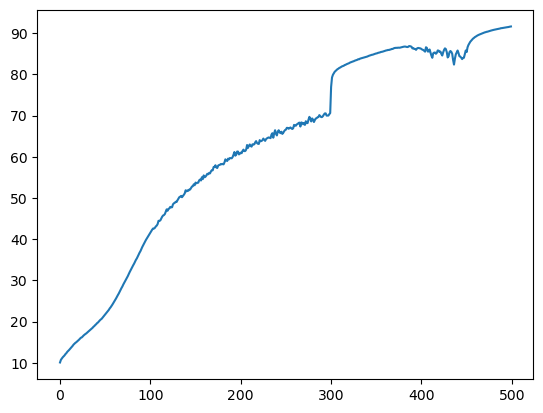

In [12]:
plt.plot(accuracies)
# lr from epoch 0 - 300 = 0.0001
# lr from epoch 300 - 450 = 0.00005
# lr from epoch 450 - 500 = 0.00001

## Evaluating the model

In [13]:
batch_size = 128
for i in range(0,len(x_test),batch_size):
    m_idx = i
    M_idx = min(i+batch_size,len(x_test))
    curr_batch_size = M_idx - m_idx
    
    x,y = x_test[m_idx : M_idx],y_test[m_idx : M_idx]

    y_pred = x.reshape(784,curr_batch_size)
    for layer in layers:
        y_pred = layer.forward(y_pred)

    accuracy += np.sum(np.argmax(y_pred,axis=0) == np.argmax(y,axis=1))

print(f'Accuracy on test dataset : {(100*accuracy/len(x_test)):.2f}%')

Accuracy on test dataset : 93.30%
